#### Use the TDA to instead of community detection and perform hubs detection

In [ ]:
import subprocess
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
plt.rcParams['svg.fonttype'] = 'none'

Import GRN

In [12]:
# Step 1: Read the content from the local file
with open('./mapper_nodes.txt', 'r') as file:
    content = file.read()

# Step 2: Interpret the content with 'eval' or 'ast.literal_eval'
# Create a dictionary to safely handle 'array'
data = eval(content, {"array": np.array})

# Step 3: Convert data to a DataFrame for easier manipulation
rows = []
for value, genes in data:
    for gene in genes:
        rows.append({'Value': value, 'Gene': gene})

df = pd.DataFrame(rows)

In [16]:
df.to_csv('Mapper_node_df.tsv', sep='\t', index=False)

In [5]:
cGRN = pd.read_csv('./Curated_gene_regulatory_network.tsv', sep='\t')
mapper_cluster = df

In [6]:
# Create an igraph Graph from the edge list
graph = ig.Graph.TupleList(cGRN[['TF', 'Target_Gene']].itertuples(index=False), directed=True)

# Print summary of the graph
print("Summary of the graph:")
print("Number of vertices:", graph.vcount())
print("Number of edges:", graph.ecount())

Summary of the graph:
Number of vertices: 1786
Number of edges: 4201


In [29]:
node_names = graph.vs['name']  # Get the names of the vertices
in_degrees = graph.degree(mode='in')  # In-degree
out_degrees = graph.degree(mode='out')  # Out-degree
total_degrees = graph.degree(mode='all')  # Total degree

degree_df = pd.DataFrame({
    'Gene_Name': node_names,
    'In_Degree': in_degrees,
    'Out_Degree': out_degrees,
    'Total_Degree': total_degrees
})

In [30]:
degree_df.to_csv('Degree_CGRN.tsv', sep='\t', index=False)

### Hub detection

Hub detection by cluster when more than 2 TFs

In [31]:
# Dictionary to store community and corresponding hub nodes
community_hubs = {}
# Dictionary to store centrality values for each node
node_centrality = {}

edge_counts = {}
nodes_counts = {}

# Iterate through communities
for community_id in mapper_cluster['Value'].unique():
    if mapper_cluster[mapper_cluster['Value'] == community_id].shape[0] >= 2 :
        sub_cGRN = cGRN[(cGRN['TF'].isin(mapper_cluster[mapper_cluster['Value'] == community_id]['Gene']))]
        subgraph = ig.Graph.TupleList(sub_cGRN[['TF', 'Target_Gene']].itertuples(index=False), directed=True)

        nodes_counts[community_id]=subgraph.vcount()
        edge_counts[community_id]=subgraph.ecount()
        # Compute centrality measures for nodes in the community subgraph
        degree_centrality = subgraph.degree()
        betweenness_centrality = subgraph.betweenness(directed=True)
        # closeness_centrality = subgraph.closeness(normalized=True)
        # eigenvector_centrality = subgraph.evcent(directed=True)
        # pagerank_centrality = subgraph.pagerank(directed=True)
        # Find nodes with the highest degree centrality
        max_degree_value = max(degree_centrality)
        max_degree_nodes = [subgraph.vs[node]["name"] for node, centrality in enumerate(degree_centrality) if centrality == max_degree_value]

        # Find nodes with the highest betweenness centrality, excluding 0
        max_betweenness_value = max(betweenness_centrality, default=None)
        if max_betweenness_value is not None and max_betweenness_value != 0:
            max_betweenness_nodes = [subgraph.vs[node]["name"] for node, centrality in enumerate(betweenness_centrality) if centrality == max_betweenness_value]
        else:
            max_betweenness_nodes = []

        # Find nodes with the highest closeness centrality
        # max_closeness_value = max(closeness_centrality)
        # max_closeness_nodes = [subgraph.vs[node]["name"] for node, centrality in enumerate(closeness_centrality) if centrality == max_closeness_value]

        # Find nodes with the highest eigenvector centrality, excluding 0
        # max_eigenvector_value = max(eigenvector_centrality, default=None)
        # if max_eigenvector_value is not None and max_eigenvector_value != 0:
        #     max_eigenvector_nodes = [subgraph.vs[node]["name"] for node, centrality in enumerate(eigenvector_centrality) if centrality == max_eigenvector_value]
        # else:
        #     max_eigenvector_nodes = []

        # Find nodes with the highest PageRank centrality, excluding 0
        # max_pagerank_value = max(pagerank_centrality, default=None)
        # if max_pagerank_value is not None and max_pagerank_value != 0:
        #     max_pagerank_nodes = [subgraph.vs[node]["name"] for node, centrality in enumerate(pagerank_centrality) if centrality == max_pagerank_value]
        # else:
        #     max_pagerank_nodes = []

        # Combine all nodes with the highest centrality values
        hub_nodes = list(set(max_degree_nodes + max_betweenness_nodes))
        # Store the hub nodes for the community
        community_hubs[community_id] = hub_nodes
        
        # Update node_centrality dictionary with centrality values for nodes in the community
        for node_index, node_name in enumerate(subgraph.vs["name"]):
            node_centrality.setdefault(node_name, {}).update({
                "Degree Centrality": degree_centrality[node_index],
                "Betweenness Centrality": betweenness_centrality[node_index],
                # "Closeness Centrality": closeness_centrality[node_index],
                # "Eigenvector Centrality": eigenvector_centrality[node_index]
                # "PageRank Centrality": pagerank_centrality[node_index]
            })

# Print the dictionary of community and corresponding hub nodes
print("Community - Hub Nodes:")
for community, hub_nodes in community_hubs.items():
    print(f"Community {community}: Hubs {hub_nodes}")

Community - Hub Nodes:
Community 0: Hubs ['Solyc02g090220', 'Solyc04g056310']
Community 2: Hubs ['Solyc06g051840']
Community 3: Hubs ['Solyc07g054220']
Community 5: Hubs ['Solyc02g077840']
Community 7: Hubs ['Solyc03g093550']
Community 9: Hubs ['Solyc07g063420', 'Solyc12g009240']
Community 18: Hubs ['Solyc07g063420', 'Solyc12g009240']
Community 19: Hubs ['Solyc12g009240', 'Solyc10g047640']
Community 13: Hubs ['Solyc09g010820', 'Solyc04g082480']
Community 11: Hubs ['Solyc06g082430']
Community 16: Hubs ['Solyc06g082430', 'Solyc10g047640']


Hub detection by cluster indep of number of TF :

In [32]:
# Dictionary to store community and corresponding hub nodes
community_hubs = {}
# Dictionary to store centrality values for each node
node_centrality = {}
edge_counts = {}
nodes_counts = {}
# Iterate through communities
for community_id in mapper_cluster['Value'].unique():
    if mapper_cluster[mapper_cluster['Value'] == community_id].shape[0] >= 1:
        sub_cGRN = cGRN[(cGRN['TF'].isin(mapper_cluster[mapper_cluster['Value'] == community_id]['Gene']))]
        subgraph = ig.Graph.TupleList(sub_cGRN[['TF', 'Target_Gene']].itertuples(index=False), directed=True)
        nodes_counts[community_id]=subgraph.vcount()
        edge_counts[community_id] = subgraph.ecount()

        # Compute centrality measures for nodes in the community subgraph
        degree_centrality = subgraph.degree()
        betweenness_centrality = subgraph.betweenness(directed=True)

        # Find top two nodes for degree centrality
        degree_centrality_with_names = [(subgraph.vs[node]["name"], centrality) for node, centrality in enumerate(degree_centrality)]
        degree_centrality_with_names.sort(key=lambda x: x[1], reverse=True)

        max_degree_nodes = degree_centrality_with_names[:1]  # Top 2 nodes
        max_degree_nodes = [node[0] for node in max_degree_nodes]  # Extract names

        # Find top two nodes for betweenness centrality
        betweenness_centrality_with_names = [(subgraph.vs[node]["name"], centrality) for node, centrality in enumerate(betweenness_centrality)]
        betweenness_centrality_with_names.sort(key=lambda x: x[1], reverse=True)

        max_betweenness_nodes = betweenness_centrality_with_names[:1]  # Top 2 nodes
        max_betweenness_nodes = [node[0] for node in max_betweenness_nodes if node[1] > 0]  # Exclude zero centrality

        # Combine all nodes with the highest centrality values
        hub_nodes = list(set(max_degree_nodes + max_betweenness_nodes))

        # Store the hub nodes for the community
        community_hubs[community_id] = hub_nodes

        # Update node_centrality dictionary with centrality values for nodes in the community
        for node_index, node_name in enumerate(subgraph.vs["name"]):
            node_centrality.setdefault(node_name, {}).update({
                "Degree Centrality": degree_centrality[node_index],
                "Betweenness Centrality": betweenness_centrality[node_index],
            })

# Print the dictionary of community and corresponding hub nodes
print("Community - Hub Nodes:")
for community, hub_nodes in community_hubs.items():
    print(f"Community {community}: Hubs {hub_nodes}")

Community - Hub Nodes:
Community 0: Hubs ['Solyc02g090220', 'Solyc04g056310']
Community 2: Hubs ['Solyc06g051840']
Community 3: Hubs ['Solyc07g054220']
Community 4: Hubs ['Solyc08g005260']
Community 5: Hubs ['Solyc02g077840']
Community 6: Hubs ['Solyc08g005260']
Community 7: Hubs ['Solyc03g093550']
Community 1: Hubs ['Solyc05g007180']
Community 8: Hubs ['Solyc02g086930']
Community 9: Hubs ['Solyc07g063420', 'Solyc12g009240']
Community 18: Hubs ['Solyc07g063420', 'Solyc12g009240']
Community 19: Hubs ['Solyc12g009240', 'Solyc10g047640']
Community 13: Hubs ['Solyc09g010820', 'Solyc04g082480']
Community 17: Hubs ['Solyc07g063420']
Community 11: Hubs ['Solyc06g082430']
Community 16: Hubs ['Solyc06g082430', 'Solyc10g047640']
Community 14: Hubs ['Solyc04g082480']
Community 15: Hubs ['Solyc09g010820']


In [33]:
# with open('Hubs_TDA_dict.txt', 'w') as file:
#     for key, value in community_hubs.items():
#         file.write('%s:%s\n' % (key,value))

In [34]:
unique_values_cluster = set(val for sublist in community_hubs.values() for val in sublist)

In [35]:
len(unique_values_cluster)

15

### Compare with previous hubs found

In [36]:
res_hubs = pd.read_csv('../Results_hubs_activity_stats.tsv',sep='\t')

In [37]:
hub_set = set(res_hubs[res_hubs['Is_Hub']]['OLN'].unique())

KeyError: 'Is_Hub'

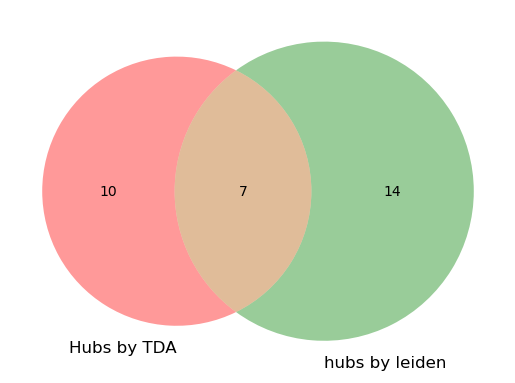

In [ ]:
venn2([unique_values_cluster,hub_set], set_labels=('Hubs by TDA','hubs by leiden'))

In [ ]:
hub_signif_tf_set = set(res_hubs[(res_hubs['Is_Hub']) & (~res_hubs['Groups'].isna())]['OLN'].unique())

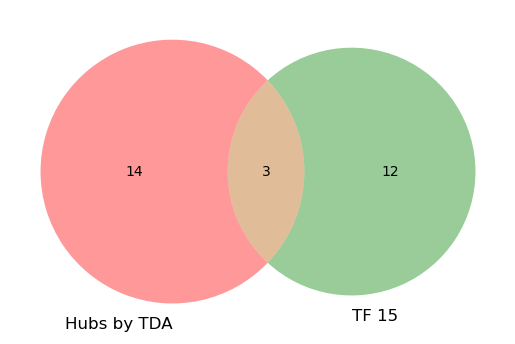

In [ ]:
venn2([unique_values_cluster,hub_signif_tf_set], set_labels=('Hubs by TDA','TF 15'))

In [ ]:
unique_values_cluster.intersection(hub_signif_tf_set)

{'Solyc02g090220', 'Solyc06g051840', 'Solyc12g009240'}

In [ ]:
signif_tf = res_hubs[~res_hubs['Groups'].isna()]

In [ ]:
set_signif_tf = set(signif_tf['OLN'].unique())

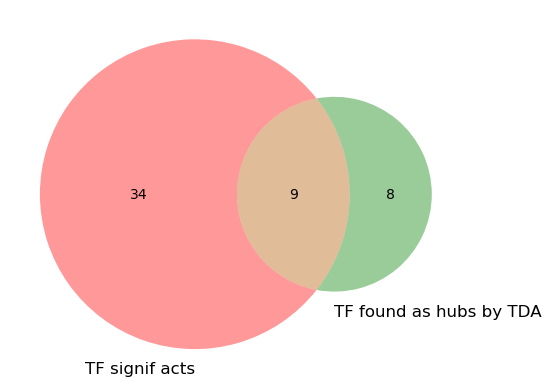

In [ ]:

venn2([set_signif_tf, unique_values_cluster], set_labels=('TF signif acts','TF found as hubs by TDA'))

In [ ]:
set_signif_tf.intersection(unique_values_cluster).intersection(hub_signif_tf_set)

{'Solyc02g090220', 'Solyc06g051840', 'Solyc12g009240'}

In [ ]:
set_signif_tf.intersection(unique_values_cluster)

{'Solyc02g077840',
 'Solyc02g090220',
 'Solyc03g093550',
 'Solyc04g056310',
 'Solyc06g051840',
 'Solyc07g054220',
 'Solyc07g063420',
 'Solyc09g010820',
 'Solyc12g009240'}

In [ ]:
tf_by_tda_acts = res_hubs[res_hubs['OLN'].isin(set_signif_tf.intersection(unique_values_cluster))]

In [ ]:
tf_by_tda_acts[['OLN','gene.family','gene.description', 'Groups']].to_csv('./Results_hubs_by_TDA_top2.tsv', sep='\t', index=False)

In [ ]:
tf_by_tda_acts[['OLN','gene.family','gene.description']]

,OLN,gene.family,gene.description
177,Solyc02g077840,ERF,Ethylene-responsive transcription factor 4 (AH...
379,Solyc04g056310,MYB,MYB transcription factor (AHRD V3.3 *-* A0A0U3...
383,Solyc02g090220,Dof,Dof zinc finger protein PBF (AHRD V3.3 *** A0A...
511,Solyc06g051840,ERF,Solanum lycopersicum Cytokinin Response Factor 6
557,Solyc03g093550,ERF,Ethylene-responsive transcription factor 5 (AH...
687,Solyc12g009240,ERF,Ethylene-responsive transcription factor (AHRD...
775,Solyc07g054220,ERF,Ethylene-responsive transcription factor (AHRD...
1006,Solyc09g010820,MYB,Myb-related protein 3R.1
1449,Solyc07g063420,NAC,NAC domain-containing protein (AHRD V3.3 *** A...


In [ ]:
tf_by_tda_acts_top1 = pd.read_csv('./Results_hubs_by_TDA.tsv', sep='\t')

In [ ]:
tf_by_tda_acts_top1

,OLN,gene.family,gene.description,Groups
0,Solyc02g077840,ERF,Ethylene-responsive transcription factor 4 (AH...,Pinfestans_pval & Cfulvum_pval & PSTVd_S23_pva...
1,Solyc04g056310,MYB,MYB transcription factor (AHRD V3.3 *-* A0A0U3...,Pinfestans_pval & Bcinerea_pval
2,Solyc02g090220,Dof,Dof zinc finger protein PBF (AHRD V3.3 *** A0A...,Pinfestans_pval & Cfulvum_pval & Bcinerea_pval
3,Solyc06g051840,ERF,Solanum lycopersicum Cytokinin Response Factor 6,Cfulvum_pval & Mincognita_7dpi_pval
4,Solyc03g093550,ERF,Ethylene-responsive transcription factor 5 (AH...,Cfulvum_pval & Bcinerea_pval & Mincognita_14dp...
5,Solyc12g009240,ERF,Ethylene-responsive transcription factor (AHRD...,Pinfestans_pval & Bcinerea_pval
6,Solyc07g054220,ERF,Ethylene-responsive transcription factor (AHRD...,PSTVd_S23_pval & Bcinerea_pval & Mincognita_14...
7,Solyc09g010820,MYB,Myb-related protein 3R.1,Pinfestans_pval & Cfulvum_pval & PSTVd_S23_pva...
8,Solyc07g063420,NAC,NAC domain-containing protein (AHRD V3.3 *** A...,Cfulvum_pval & Bcinerea_pval


In [ ]:
set_top1 = set(tf_by_tda_acts_top1['OLN'].unique())

In [ ]:
set_signif_tf.intersection(unique_values_cluster).difference(set_top1)

set()

### Assigning gene to cluster in the results

In [38]:
def expand_dataframe(community_dict):
    expanded_rows = []
    
    for gene, communities in community_dict.items():
        for community in communities:
            expanded_rows.append([gene, community])  # Append as a list of values
    
    return pd.DataFrame(expanded_rows, columns=['Cluster', 'OLN'])

In [39]:
expanded_df = expand_dataframe(community_hubs)

In [40]:
expanded_df

,Cluster,OLN
0,0,Solyc02g090220
1,0,Solyc04g056310
2,2,Solyc06g051840
3,3,Solyc07g054220
4,4,Solyc08g005260
5,5,Solyc02g077840
6,6,Solyc08g005260
7,7,Solyc03g093550
8,1,Solyc05g007180
9,8,Solyc02g086930


In [41]:
expand_res_hubs = pd.merge(res_hubs,expanded_df, on='OLN', how='right')

In [42]:
expand_res_hubs['OLN'].unique().shape

(15,)

In [43]:
#expand_res_hubs.to_csv('Results_hubs_with_TDA_cluster.txt', sep='\t', index=False)

In [44]:
TF_2_cluster = pd.read_csv('./TFs_to_clusters_TDA.tsv', sep='\t')
TF_2_cluster.rename(columns={'Gene':'OLN'}, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: './TFs_to_clusters_TDA.tsv'

In [ ]:
import ast
TF_2_cluster['Clusters'] = TF_2_cluster['Clusters'].apply(ast.literal_eval)
expand_dataframe_TF_2_cluster = TF_2_cluster.explode('Clusters').reset_index(drop=True)

In [ ]:
expand_res = pd.merge(res_hubs,expand_dataframe_TF_2_cluster, on='OLN', how='right')

In [ ]:
expand_res['OLN'].unique().shape

(71,)

In [ ]:
#expand_res.to_csv('Results_with_TDA_cluster.txt', sep='\t', index=False)

*********

### Hub by grouping similar cluster

Thanks to the adjacency plots, we identified 4 mega clusters defined as :
- 1 - 0+2+3+5 (multiple shared)
- 2 - 7+19 (spe shared)
- 3 - 18+9+13+17 (multiple exclusif)
- 4 - 11 (spe exclusif)

We can identifed hubs on these mega clusters

In [17]:
custom_cluster = {1: [0,2,3,5],
                  2: [7],
                  3: [9,18,13,15,17,11],
                  4: [19]}
# Dictionary to store community and corresponding hub nodes
community_hubs = {}
# Dictionary to store centrality values for each node
node_centrality = {}
edge_counts = {}
nodes_counts = {}
## Save the TFs in each mega cluster
TF_in_mega_cluster_saved = {}
# Iterate through communities
for community_id in custom_cluster:
    
    TF_in_mega_cluster = mapper_cluster[mapper_cluster['Value'].isin(custom_cluster[community_id])]['Gene'].unique() # Find unique TF in the mega cluster
    TF_in_mega_cluster_saved[community_id] = TF_in_mega_cluster
    sub_cGRN = cGRN[(cGRN['TF'].isin(TF_in_mega_cluster))] # Retrieve the subGRN composed of the TF in the mega cluster
    subgraph = ig.Graph.TupleList(sub_cGRN[['TF', 'Target_Gene']].itertuples(index=False), directed=True) #create the subgraph
    nodes_counts[community_id] = subgraph.vcount()
    edge_counts[community_id] = subgraph.ecount()

    # Compute centrality measures for nodes in the community subgraph
    degree_centrality = subgraph.degree()
    betweenness_centrality = subgraph.betweenness(directed=True)

    # Find top two nodes for degree centrality
    degree_centrality_with_names = [(subgraph.vs[node]["name"], centrality) for node, centrality in enumerate(degree_centrality)]
    degree_centrality_with_names.sort(key=lambda x: x[1], reverse=True)

    max_degree_nodes = degree_centrality_with_names[:1]  # Top 2 nodes
    max_degree_nodes = [node[0] for node in max_degree_nodes]  # Extract names

    # Find top two nodes for betweenness centrality
    betweenness_centrality_with_names = [(subgraph.vs[node]["name"], centrality) for node, centrality in enumerate(betweenness_centrality)]
    betweenness_centrality_with_names.sort(key=lambda x: x[1], reverse=True)

    max_betweenness_nodes = betweenness_centrality_with_names[:1]  # Top 2 nodes
    max_betweenness_nodes = [node[0] for node in max_betweenness_nodes if node[1] > 0]  # Exclude zero centrality

    # Combine all nodes with the highest centrality values
    hub_nodes = list(set(max_degree_nodes + max_betweenness_nodes))

    # Store the hub nodes for the community
    community_hubs[community_id] = hub_nodes

    # Update node_centrality dictionary with centrality values for nodes in the community
    for node_index, node_name in enumerate(subgraph.vs["name"]):
        node_centrality.setdefault(node_name, {}).update({
            "Degree Centrality": degree_centrality[node_index],
            "Betweenness Centrality": betweenness_centrality[node_index],
        })

# Print the dictionary of community and corresponding hub nodes
print("Community - Hub Nodes:")
for community, hub_nodes in community_hubs.items():
    print(f"Community {community}: Hubs {hub_nodes}")

Community - Hub Nodes:
Community 1: Hubs ['Solyc07g054220', 'Solyc06g051840']
Community 2: Hubs ['Solyc03g093550']
Community 3: Hubs ['Solyc06g082430', 'Solyc07g063420']
Community 4: Hubs ['Solyc12g009240', 'Solyc10g047640']


In [18]:
df = pd.DataFrame([(key, value) for key, values in TF_in_mega_cluster_saved.items() for value in values],
                  columns=['Mega_Cluster', 'TF'])

In [48]:
# df.to_csv('TF_in_mega_cluster.tsv', sep='\t', index=False)

Compare with activity

In [28]:
def expand_dataframe(community_dict):
    expanded_rows = []
    
    for gene, communities in community_dict.items():
        for community in communities:
            expanded_rows.append([gene, community])  # Append as a list of values
    
    return pd.DataFrame(expanded_rows, columns=['Cluster', 'OLN'])

In [23]:
res_hubs = pd.read_csv('../Results_hubs_activity_stats.tsv',sep='\t')

In [20]:
pd.set_option('display.max_colwidth', None)

In [21]:
Hubs_mega_cluster = [TF for TFs in community_hubs.values() for TF in TFs]

In [24]:
res_mega_cluster = res_hubs[res_hubs['OLN'].isin(Hubs_mega_cluster)][['OLN','Groups', 'gene.description', 'gene.family']]

In [25]:
res_mega_cluster[~res_mega_cluster['Groups'].isna()]['OLN'].to_list()

['Solyc03g093550',
 'Solyc06g051840',
 'Solyc07g054220',
 'Solyc07g063420',
 'Solyc12g009240']

In [29]:
expanded_df = expand_dataframe(community_hubs)

In [31]:
res_comm = pd.merge(res_mega_cluster,expanded_df, on='OLN', how='right')

In [32]:
res_comm = res_comm[~res_comm['Groups'].isna()]

In [33]:
res_comm.rename(columns={'Cluster':'Mega_Cluster'}, inplace=True)

In [34]:
res_comm

,OLN,Groups,gene.description,gene.family,Mega_Cluster
0,Solyc07g054220,PSTVd_S23_pval & Bcinerea_pval & Mincognita_14dpi_pval,Ethylene-responsive transcription factor (AHRD V3.3 *** A0A2G3C0R2_CAPCH),ERF,1
1,Solyc06g051840,Cfulvum_pval,Solanum lycopersicum Cytokinin Response Factor 6,ERF,1
2,Solyc03g093550,Bcinerea_pval & Mincognita_14dpi_pval,Ethylene-responsive transcription factor 5 (AHRD V3.3 *** A0A2G3CVP7_CAPCH),ERF,2
4,Solyc07g063420,Cfulvum_pval & Bcinerea_pval,NAC domain-containing protein (AHRD V3.3 *** A0A2U1LQQ4_ARTAN),NAC,3
5,Solyc12g009240,Bcinerea_pval,Ethylene-responsive transcription factor (AHRD V3.3 *-* A0A2G3BP26_CAPCH),ERF,4


In [35]:
res_comm.to_csv('./Results_hubs_by_TDA_mega_cluster.tsv', sep='\t', index=False)

In [ ]:
# res_comm['OLN'].to_csv('./Hubs_ID_mega_cluster.txt', sep='\t', index=False, header=False)

In [ ]:
df[df['TF'].isin(res_hubs[~res_hubs['Groups'].isna()]['OLN'].unique())].to_csv('TF_signif_in_mega_cluster.tsv', sep='\t', index=False)

In [ ]:
custom_cluster = {1: [0,2,3,5],
                  2: [7],
                  3: [19,9,18,13,15,17],
                  4: [11]}

In [ ]:
mapper_cluster[mapper_cluster['Value'].isin(custom_cluster[4])]['Gene'].unique().tofile('TF_in_mega_cluster_4.tsv', sep='\n', format='%s')

----

In [ ]:
tf_counts = mapper_cluster['Value'].value_counts().to_dict()

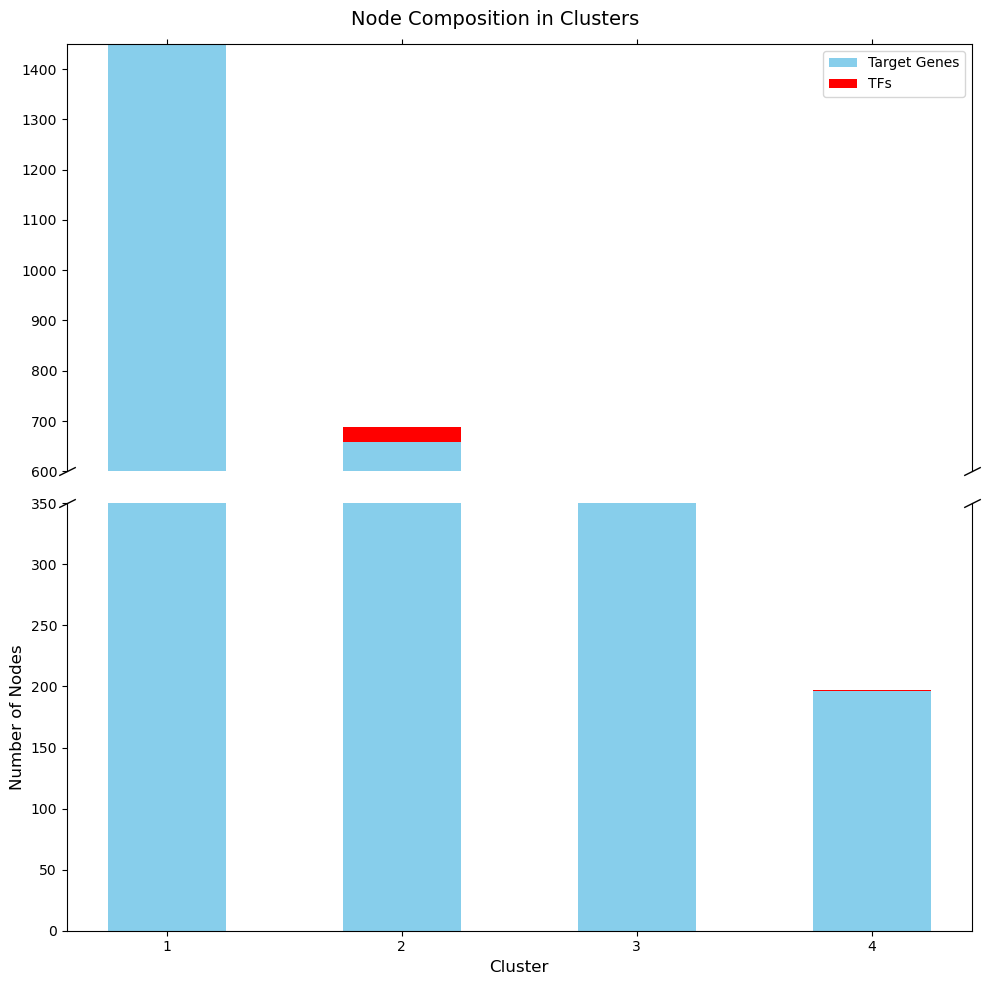

In [ ]:
# Step 2: Combine data into a new dataframe
plot_data = []
for community, size in edge_counts.items():
    tf_count = tf_counts.get(community, 0)  # Get TF count, default to 0 if not present
    non_tf_count = size - tf_count  # Remaining nodes in the community
    plot_data.append({'Cluster': community, 'TF': tf_count, 'Non-TF': non_tf_count})

plot_df = pd.DataFrame(plot_data)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)# adjust space between Axes
fig.set_size_inches(10, 10)
# Step 3: Create a stacked bar plot

bar_width = 0.5

# Plot Non-TF nodes
ax1.bar(
    plot_df['Cluster'],
    plot_df['Non-TF'],
    color='skyblue',
    label='Target Genes',
    width=bar_width
)

# Plot TF nodes on top
ax1.bar(
    plot_df['Cluster'],
    plot_df['TF'],
    bottom=plot_df['Non-TF'].values,
    color='red',
    label='TFs',
    width=bar_width
)
# Plot Non-TF nodes
ax2.bar(
    plot_df['Cluster'],
    plot_df['Non-TF'],
    color='skyblue',
    label='Target Genes',
    width=bar_width
)

# Plot TF nodes on top
ax2.bar(
    plot_df['Cluster'],
    plot_df['TF'],
    bottom=plot_df['Non-TF'].values,
    color='red',
    label='TFs',
    width=bar_width
)

ax2.set_ylim(0, 350)
ax1.set_ylim(600, 1450)
# Step 4: Customize the plot
ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Number of Nodes', fontsize=12)
fig.suptitle('Node Composition in Clusters', fontsize=14)
ax2.set_xticks(ticks=plot_df['Cluster'], labels=plot_df['Cluster'])
ax1.legend(loc='upper right', fontsize=10)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
custom_cluster = {1: [0,2,3,5],
                  2: [7,19],
                  3: [9,18,13,15,17],
                  4: [11]}
cluster_to_mega = {cluster: mega for mega, clusters in custom_cluster.items() for cluster in clusters}

In [ ]:
plot_df['MegaCluster'] = plot_df['Cluster'].map(cluster_to_mega)
plot_df['MegaCluster']=plot_df['MegaCluster'].replace(np.nan, 0)

In [ ]:
plot_df

,Cluster,TF,Non-TF,MegaCluster
0,1,1,2731,0.0
1,2,31,658,1.0
2,3,19,529,1.0
3,4,1,196,0.0


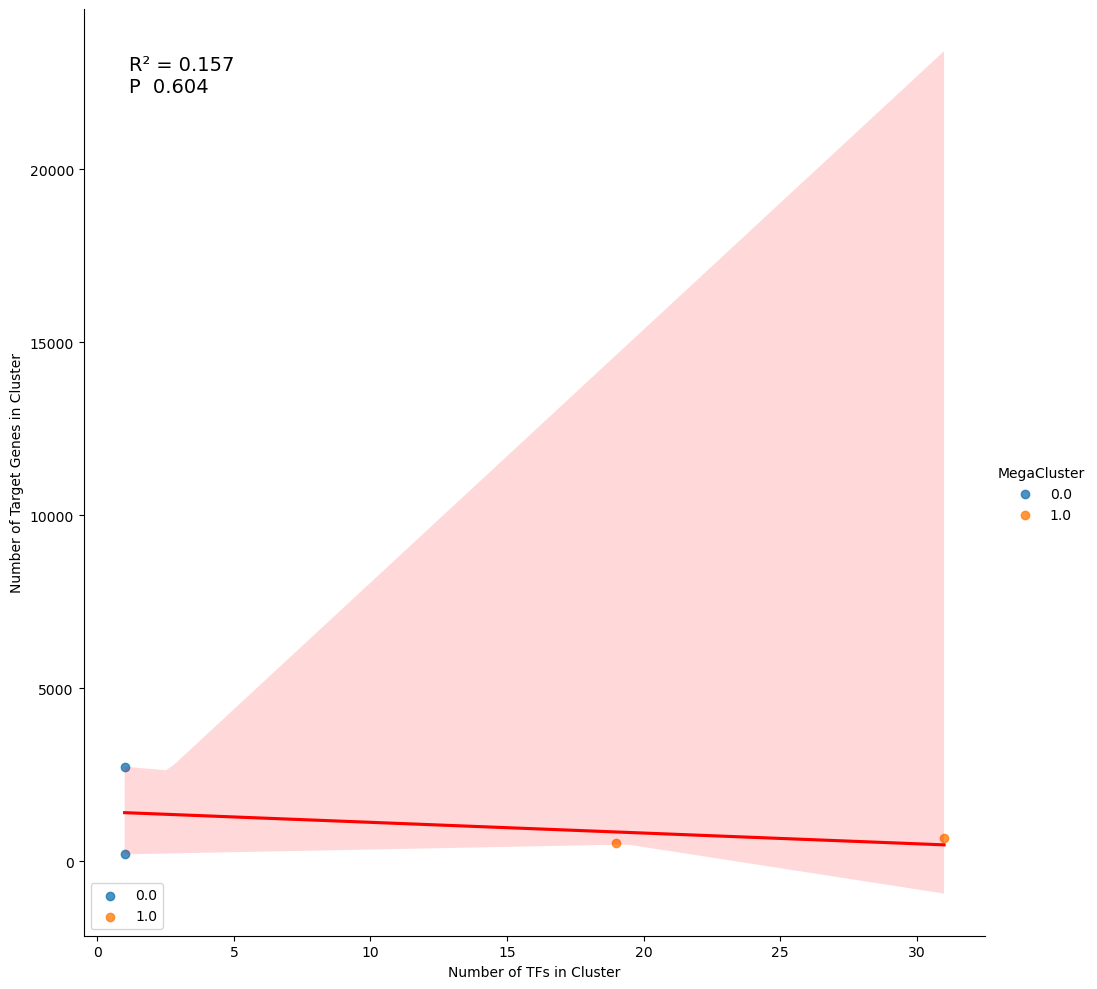

In [ ]:
from scipy.stats import linregress
# Step 1: Perform linear regression using scipy
slope, intercept, r_value, p_value, std_err = linregress(plot_df['TF'], plot_df['Non-TF'])

# Step 2: Calculate R² value
r_squared = r_value**2

# Step 3: Create the plot
g = sns.lmplot(x='TF', y='Non-TF', hue='MegaCluster', data=plot_df, fit_reg=False, height=10, aspect=1)
sns.regplot(x='TF', y='Non-TF', data=plot_df, scatter=False, line_kws={'color': 'red'})
# Step 4: Display the R² value and p-value on the plot
plt.xlabel('Number of TFs in Cluster')
plt.ylabel('Number of Target Genes in Cluster')

# Format the p-value for readability
if p_value < 0.001:
    p_text = '< 0.001'
else:
    p_text = f'{p_value:.3f}'

# Add R² and p-value text to the plot
plt.text(
    0.05, 0.95, 
    f'R² = {r_squared:.3f}\nP  {p_text}', 
    transform=plt.gca().transAxes, 
    fontsize=14, 
    verticalalignment='top'
)

# Show the plot
plt.legend()
plt.show()

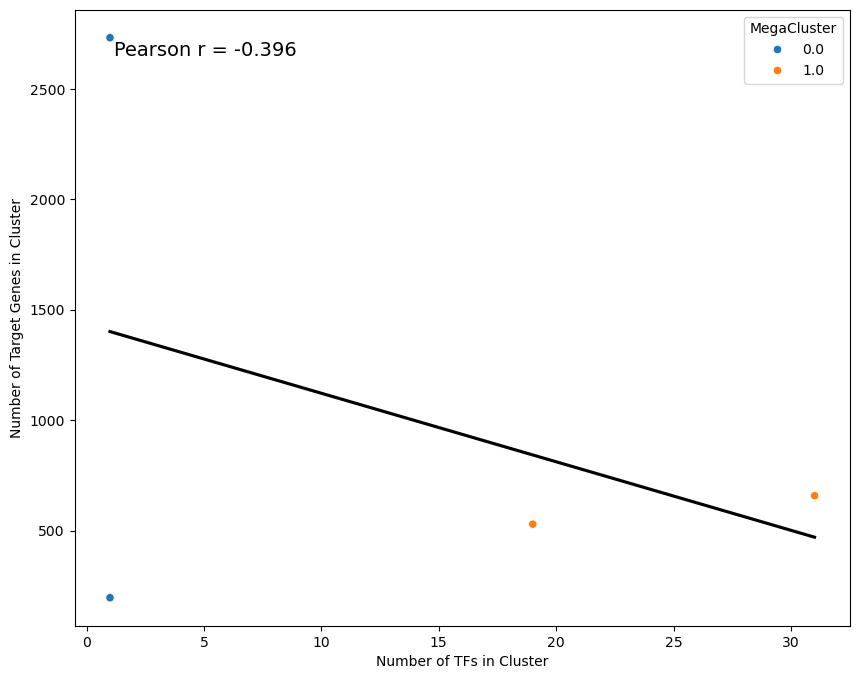

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute Pearson correlation coefficient globally
corr_coeff, p_value = pearsonr(plot_df['TF'], plot_df['Non-TF'])

# Create figure and axis
plt.figure(figsize=(10, 8))

# Plot the regression line globally (without hue)
sns.regplot(
    x='TF', y='Non-TF', data=plot_df, 
    scatter=False, color='black', ci=None  # Regression line only
)

# Scatter plot with color by MegaCluster
sns.scatterplot(
    x='TF', y='Non-TF', hue='MegaCluster', data=plot_df, 
    palette='tab10'
)

# Format the p-value for readability
# p_text = '< 0.001' if p_value < 0.001 else f'{p_value:.3f}'

# Add Pearson correlation coefficient and p-value text
plt.text(
    0.05, 0.95, 
    f'Pearson r = {corr_coeff:.3f}', 
    transform=plt.gca().transAxes, 
    fontsize=14, 
    verticalalignment='top'
)

# Labels
plt.xlabel('Number of TFs in Cluster')
plt.ylabel('Number of Target Genes in Cluster')

# Show the legend and plot
plt.legend(title="MegaCluster")
plt.show()
